## Seq2seq으로 번역기 만들기
- 데이터 전처리
- 모델 설계
- 훈련하기
- 시각화


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
# matplot은 한국어를 지원하지 않기 때문에 한글로 처리하는 작업
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

### 데이터 준비하기

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os

print(tf.__version__)

2.6.0


In [3]:
# tensforflow에서 제공하는 함수를 사용하여 데이터를 다운로드 받는다
path = os.getenv("HOME") + '/aiffel/korean-parallel-corpora'
print(path)
path_to_en = path +"/korean-english-news-v1/korean-english-park.train.en"
path_to_kr = path +"/korean-english-news-v1/korean-english-park.train.ko"

/aiffel/aiffel/korean-parallel-corpora


In [4]:
# 데이터 형태 읽어오기
with open(path_to_en,'r', encoding='utf-8') as f:
    raw_en = f.read().splitlines()

print("Data Size:", len(raw_en))
print("Example:")

for sen in raw_en[:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [5]:
# 데이터 형태 읽어오기
with open(path_to_kr,'r', encoding='utf-8') as f:
    raw_ko = f.read().splitlines()

print("Data Size:", len(raw_ko))
print("Example:")

for sen in raw_ko[:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [6]:
df = pd.DataFrame(raw_en, columns = ['EN'])
df['KR'] = np.array(raw_ko)
df

,EN,KR
0,"Much of personal computing is about ""can you t...","개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?"""
1,so a mention a few weeks ago about a rechargea...,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,"Like all optical mice, But it also doesn't nee...",그러나 이것은 또한 책상도 필요로 하지 않는다.
3,uses gyroscopic sensors to control the cursor ...,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,Intelligence officials have revealed a spate o...,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...
...,...,...
94118,””We are hoping to seize material evidence to ...,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...
94119,"” On Monday, police secured statements from si...",월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.
94120,But the lack of material evidence is making it...,그러나 불충분한 증거 확보로 수사에 어려움이 있다.
94121,Kim and his son both deny the allegations.,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.


In [7]:
# 중복 데이터 제거하기
cleaned_corpus = df.drop(df[df['EN'].duplicated()].index)
cleaned_corpus.head()

,EN,KR
0,"Much of personal computing is about ""can you t...","개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?"""
1,so a mention a few weeks ago about a rechargea...,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,"Like all optical mice, But it also doesn't nee...",그러나 이것은 또한 책상도 필요로 하지 않는다.
3,uses gyroscopic sensors to control the cursor ...,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,Intelligence officials have revealed a spate o...,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...


In [8]:
# 중복 데이터가 제거된 values cleaned corpus에 저장
cleaned_corpus = cleaned_corpus[['EN','KR']].values
cleaned_corpus.shape

(75598, 2)

### Module

In [9]:
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

# 표제어 추출
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
le = WordNetLemmatizer()

# 
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /aiffel/nltk_data...


In [10]:
# 데이터 전처리 함수 재정의
# https://gggggeun.tistory.com/183
def preprocessing(sentence, is_english=True):
    # 한국어 불용어 list
    stopwords_kr = ['의', '가','로', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한','가량',  '간', '갖은', '개국', '개년', '개소', '개월', '걔', '거', ]
    #Lucene = '거기, 건, 것, 겨를, 격, 겸, 고, 군, 군데, 권, 그, 그거, 그것, 그곳, 그까짓, 그네,  그놈, 그대, 그래, 그래도,그서, 그러나, 그러니, 그러니까, 그러다가, 그러면, 그러면서, 그러므로, 그러자, 그런, 그런데, 그럼, 그렇지만, 그루, 그리고, 그리하여, 그분, 그이, 그쪽, 근, 근데, 글쎄, 글쎄요, 기,김, 나름, 나위, 남짓,  냥, 너, 너희, 네, 네놈, 녀석, 년대, 년도, 놈, 누구, 니,다른, 다만, 단, 달 대, 대로, 더,구나, 더욱이, 데, 도, 동, 되, 두, 두세, 두어,둥, 듯, 듯이, 등, 등등, 등지, 따라서, 따름, 따위, 딴, 때문, 또, 또는, 또한, 리, 마당, 마련,마리, 만, 만큼, 말, 맨, 몇, 몇몇, 모, 모금, 모든, 무렵, 무슨, 뭐, 뭣, 미터,및, 바, 박, 발, 발짝, 번, 법, 별, 본, 부, 분, 뻔, 뿐, 살,서너, 석, 설,섬, 세, 세기, 셈, 쇤네, 수, 순, 스무, 승, 시, 시간, 식, 씨, 아, 아냐, 아니,아무개, 아무런, 아아, 아이, 아이고, 아이구, 야, 약, 양, 얘, 어,  어머, 에이,엔, 여기, 여느, 여보, 여보세요, 여지, 역시, 예, 옛, 오, 오랜, 오히려, 온, 온갖,올, 왜냐하면, 왠, 외, 요, 우리, 원, 월, 웬, 위, 음, 응, 이, 이거, 이것, 이곳, 이놈, 이래,이런, 이런저런, 이른바, 이리하여, 이쪽, 일, 일대, 임마, 자, 자기, 자네, 장, 저, 저것, 저기,저놈, 저런, 저쪽, 저편, 저희, 적, 전, 점, 제, 조, 주, 주년, 주일, 줄, 중, 즈음, 즉, 지, 지경, 짝, 쪽, 쯤, 차, 참, 채, 척, 첫, 체, 초, 총, 측, 치, 타, 터, 턱, 톤,통, 투, 판, 퍼센트, 편, 평, 푼, 하기야, 하긴, 하물며, 하지만, 한, 한두, 한편, 허허, 헌, 현,호, 회, 흥'.split(', ')
    #stopwords_kr += Lucene
    
    # 영어 불용어 list - NLTK
    stopwords_en = set(stopwords.words('english'))

    sentence = sentence.lower().strip()
    
    # 영어
    if is_english:
        # 1-2글자 제거
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.split()
        # 불용어 제거
        sentence = [word for word in sentence if word not in stopwords_en]
        # 표제어 추출
        sentence = [le.lemmatize(word) for word in sentence]
        # 어간 추출
        #sentence = [stemmer.stem(word) for word in sentence]

        sentence = ['<start>'] + sentence + ['<end>']
        sentence = ' '.join(sentence)
    # 한국어
    else:
        sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]+", "", sentence)
        sentence = mecab.morphs(sentence)
        sentence = [word for word in sentence if word not in stopwords_kr]
        sentence = ' '.join(sentence)


    return sentence

In [11]:
# 토큰화
def tokenize(corpus):
    # out of vocabulary에 토큰 처리 - nan 값에 '0'으로 대체했기 때문에 처리한다
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 10000 ,filters ='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    # padding을 해주고 maxlen은 문장 최대 길이로 설정했다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen = 50)

    return tensor, tokenizer

In [12]:
# Bahdanau alignment score Attention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]
        
        #  W * h_enc
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        # W * h_dec
        h_dec = self.w_dec(h_dec)
        
        #  Bahdanau , w_com -> V.T
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        # alignment score 값을 확률분포로 만들어준다
        attn = tf.nn.softmax(score, axis=1)
        
        # C = W(attn) * h_encoder
        context_vec = attn * h_enc
        # 출력된 값의 합을 구하면 각 timestep마다 주목해야 할 단어에 강조되는 context vector를 구할 수 있따.
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

    

In [13]:
# GRU 인코더
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [14]:
# GRU 디코더
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        #self.masking = Masking(mask_value=0.0)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        #out = self.masking(out)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [15]:
# 평가
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

# Attention map 시각화
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(len(sentence) + 1)))
    ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(len(predicted_sentence) + 1)))


    plt.show()

# 번역
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))




In [16]:
# 손실 함수 정의
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)


In [17]:
# train step으로 loss를 계산한 후 반환하는 함수
#@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0
    
    # 모든 연산을 기록하는 테이프 , 스텝의 최종 단계에서 미분 값을 구하는데 사용된다
    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


In [18]:
# Test loss 
#@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [19]:
from konlpy.tag import Mecab

mecab = Mecab()

def preprocess_sentence(sentence, is_english=False, s_token=False, e_token=False):
    # 한국어 불용어 list
    stopwords_kr = ['의', '가','로', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한','가량', '간', '갖은', '개국', '개년', '개소', '개월', '걔', '거' ]
    #Lucene = '거기, 건, 것, 겨를, 격, 겸, 고, 군, 군데, 권, 그, 그거, 그것, 그곳, 그까짓, 그네,  그놈, 그대, 그래, 그래도,그서, 그러나, 그러니, 그러니까, 그러다가, 그러면, 그러면서, 그러므로, 그러자, 그런, 그런데, 그럼, 그렇지만, 그루, 그리고, 그리하여, 그분, 그이, 그쪽, 근, 근데, 글쎄, 글쎄요, 기,김, 나름, 나위, 남짓,  냥, 너, 너희, 네, 네놈, 녀석, 년대, 년도, 놈, 누구, 니,다른, 다만, 단, 달 대, 대로, 더,구나, 더욱이, 데, 도, 동, 되, 두, 두세, 두어,둥, 듯, 듯이, 등, 등등, 등지, 따라서, 따름, 따위, 딴, 때문, 또, 또는, 또한, 리, 마당, 마련,마리, 만, 만큼, 말, 맨, 몇, 몇몇, 모, 모금, 모든, 무렵, 무슨, 뭐, 뭣, 미터,및, 바, 박, 발, 발짝, 번, 법, 별, 본, 부, 분, 뻔, 뿐, 살,서너, 석, 설,섬, 세, 세기, 셈, 쇤네, 수, 순, 스무, 승, 시, 시간, 식, 씨, 아, 아냐, 아니,아무개, 아무런, 아아, 아이, 아이고, 아이구, 야, 약, 양, 얘, 어,  어머, 에이,엔, 여기, 여느, 여보, 여보세요, 여지, 역시, 예, 옛, 오, 오랜, 오히려, 온, 온갖,올, 왜냐하면, 왠, 외, 요, 우리, 원, 월, 웬, 위, 음, 응, 이, 이거, 이것, 이곳, 이놈, 이래,이런, 이런저런, 이른바, 이리하여, 이쪽, 일, 일대, 임마, 자, 자기, 자네, 장, 저, 저것, 저기,저놈, 저런, 저쪽, 저편, 저희, 적, 전, 점, 제, 조, 주, 주년, 주일, 줄, 중, 즈음, 즉, 지, 지경, 짝, 쪽, 쯤, 차, 참, 채, 척, 첫, 체, 초, 총, 측, 치, 타, 터, 턱, 톤,통, 투, 판, 퍼센트, 편, 평, 푼, 하기야, 하긴, 하물며, 하지만, 한, 한두, 한편, 허허, 헌, 현,호, 회, 흥'.split(', ')
    #stopwords_kr += Lucene
    
    # 영어 불용어 list - NLTK
    stopwords_en = set(stopwords.words('english'))
    sentence = sentence.lower().strip()
    if is_english:
        # 1-2글자 제거
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
        sentence = sentence.strip()
    
    else:
        sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]+", "", sentence)
        sentence = mecab.morphs(sentence)
        tokens = [word for word in sentence if word not in stopwords_kr]
        sentence = " ".join(tokens)

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence


### 데이터 준비

In [20]:
# data load 함수
# 전처리, 토큰화 , train_test_split
cleaned_corpus[2][0]

"Like all optical mice, But it also doesn't need a desk."

In [21]:
from konlpy.tag import Mecab
# 데이터 상위 3만개 사용
num_examples = 30000

# 추가된 한글 정규식 및 Mecab 객체 생성
#kr_pattern = re.compile("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]+")
mecab = Mecab()

cleaned_corpus_en = [preprocessing(en[0], is_english=True) for en in cleaned_corpus]
cleaned_corpus_kr = [preprocessing(kr[1], is_english=False) for kr in cleaned_corpus]

print(cleaned_corpus_en[0])
print(cleaned_corpus_kr[1])

<start> much personal computing top this? <end>
모든 광 마우스 마찬가지 광 마우스 책상 위 놓 마우스 패드 필요 하 지 않 는다


In [22]:
print(cleaned_corpus_en[1])
print(cleaned_corpus_kr[1])

<start> mention week ago rechargeable wireless optical mouse brought another rechargeable, wireless mouse. <end>
모든 광 마우스 마찬가지 광 마우스 책상 위 놓 마우스 패드 필요 하 지 않 는다


In [23]:
print(len(cleaned_corpus_en))
print(len(cleaned_corpus_kr))

75598
75598


In [24]:
# 토큰 길이가 40 이하인 데이터 선별
eng_corpus = [en for i,(en,kr) in enumerate(zip(cleaned_corpus_en,cleaned_corpus_kr))  if len(kr) < 40]
kor_corpus = [kr for i,(en,kr) in enumerate(zip(cleaned_corpus_en,cleaned_corpus_kr))  if len(kr) < 40]


#eng_corpus_df = pd.DataFrame(cleaned_corpus_en)
#kor_corpus_df = pd.DataFrame(cleaned_corpus_kr)
##kor_corpus_v = kor_corpus_df.drop(pd.DataFrame(kor_corpus).index).fillna('0').values.tolist()
#eng_corpus_v = eng_corpus_df.drop(pd.DataFrame(kor_corpus).index).fillna('0').values.tolist()

In [25]:
# 결과 확인
print("Number of English Sentences:", len(eng_corpus))
print("Number of Korean Sentences:", len(kor_corpus))

Number of English Sentences: 17888
Number of Korean Sentences: 17888


In [26]:
eng_corpus[2]

'<start> something boost capability crucial moment important. <end>'

In [27]:
kor_corpus[2]

'결정 적 인 순간 그 능력 을 증가 시켜 줄 그 무엇 매우 중요 합니다'

In [28]:
start = 0
for d in eng_corpus:
    maxlen = max(start, len(d))
    start = len(d)
print(maxlen)
start = 0
for d in kor_corpus:
    maxlen = max(start, len(d))
    start = len(d)
print(maxlen)

84
33


### 데이터 전처리 : 토큰화

In [29]:
# Tokenize the preprocessed sentences
enc_tensor, enc_tokenizer =  tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

# Split the data into training and validation sets
#enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2)

# Display the shapes of the training and valida|tion sets
print("Encoder Train:", enc_tensor.shape)
print("Decoder Train:", dec_tensor.shape)

# You can also display the shapes of the validation sets if needed
#print("Encoder Validation:", enc_val.shape)
#print("Decoder Validation:", dec_val.shape)


Encoder Train: (17888, 50)
Decoder Train: (17888, 50)


In [30]:
print(len(enc_tokenizer.index_word),
len(dec_tokenizer.index_word) + 1)

16913 24272


### 모델 설계

In [31]:
from tensorflow.keras.layers import Masking
# 코드를 실행하세요.
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 128
embedding_dim = 256

# GRU Encoder 생성
encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
# GRU Decoder 생성
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 50

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
# Encoder Output
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))
# Decoder output - decoder hidden state, attention
sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 50, 128)
Decoder Output: (64, 24272)
Decoder Hidden State: (64, 128)
Attention: (64, 50, 1)


### 훈련하기 - Optimizer & Loss

In [32]:
print(enc_tensor[30])
print(dec_tensor[30])

[ 202 6484 6485  584 2628   81  166   48   27    4    2    8    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[   1   13 7721   35  697  253  518   59   54    2    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [34]:
from tqdm import tqdm
import random

EPOCHS = 50

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0,enc_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx:idx+BATCH_SIZE],
                                dec_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
'''
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))
'''    


Epoch 50: 100%|██████████| 280/280 [03:46<00:00,  1.24it/s, Loss 0.3322]


"\n    test_loss = 0\n    \n    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))\n    random.shuffle(idx_list)\n    t = tqdm(idx_list)\n\n    for (test_batch, idx) in enumerate(t):\n        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],\n                                    dec_val[idx:idx+BATCH_SIZE],\n                                    encoder,\n                                    decoder,\n                                    dec_tokenizer)\n    \n        test_loss += test_batch_loss\n\n        t.set_description_str('Test Epoch %2d' % (epoch + 1))\n        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))\n"

### Attention Map

In [ ]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

## 결과
### 1 result : Test Loss 5.1134
- optimizer Adam 
- batch size = 128
- sentence len = 25
- epochs = 10
- unit = 516
- embedding dim = 516
- 처음에는 아주 기본적인 전처리만 진행주었다. 영어는 공백을 기준으로 split을 해주는 정도만 진행했고 한국어도 통용적으로 사용되는 정규식 처리해준 것이 다였다. 
- loss는 안정적으로 떨어졌지만 좋은 성능을 내지는 못했다. epochs를 10번밖에 돌리지 않아서 더 돌려보려고 했지만 일단 loss값 자체가 높아서 데이터 처리가 더 필요하다는 생각이 들어서 영어와 한국어 모두 전처리를 더 해주었다. 영어는 문자 사이의 공백을 주고 ?,!같은 문자들을 제거하지 않았고 한국어 같은 경우에는 불용어 제거를 추가적으로 해주었다.
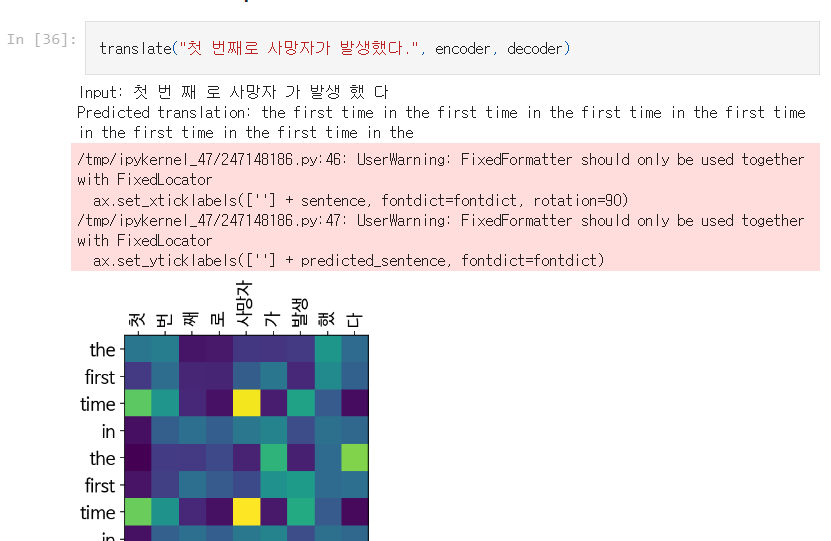

### 2 result :  Loss 4.6122
- optimizer Adam
- batch size = 128
- sentence len = 25
- epochs = 10
- unit = 64
- embedding dim = 256
- 불용어를 좀 더 처리해보기로 했다. 한국어 불용어 논문을 참고해서 가져와서 사용했고 영어도 NLTK를 사용해서 불용어를 제거해주었다. maxlen도 최대가 20이기 때문에 20으로 설정해주었다

### 3 result :0.3322
- batch size = 64
- sentence len = 50
- epochs = 10
- unit = 128
- embedding dim = 256


### 회고
- 처음에 loss값이 높게 나와서 토큰화나 전처리에 더 집중하여 처리하려고 했다. 그런데 나중에 코드르 보니까 문장 길이가 40 이하인 데이터를 가져와 쓰는 부분에서 토큰 개수라고 생각하여 토큰 개수로 처리했다. 이 부분을 원래 의도처럼 문장길이가 40이하 데이터로 처리해주고 나니까 갑자기 loss가 확 떨어졌다. 
- loss가 떨어지는데 많이 기여한 부분이 생성할 문장의 길이였다. 처음에 20으로 했던 것을 50으로 늘려주니까 3.대로 시작하던 loss가 2.~1.대의 loss로 처음 시작을 했다. 너무 생성할 문장의 길이를 작게 잡은 것도 문제가 되었던 것 같다.